In [3]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
plt.style.use('bmh')
plt.style.use('seaborn-talk')
plt.rcParams["figure.figsize"] = [12,7]
# Root
machine = 'local' # 'local' or 'remote'
if machine == 'local':
    root = r'D:\ESRP\RechargeData_Alex'
elif machine == 'remote':
    root = r'P:\AMoody\ESRP\RechargeData_Alex'

sys.path.append(os.path.join(root,'FPT','Wetlands'))
sys.path.append(os.path.join(root,'FPT'))

In [4]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


# Updates to ESPAM2.2 Water Budget
January 2015 - September 2017

### Outline
1. Compare growing season METRIC ET with ETIdaho estimates in overlapping years
2. Compare ARIMA models of 2017 ETIdaho vs. monthly means
3. Examine updated water budget components
    + DIV
    + PCH
    + FPT
    + NIR
    + TRB
    + OFF

In [13]:
# Stress periods dictionary
stress_periods = ['S{0:03d}'.format(x) for x in  np.arange(1,450)]
stress_ts = pd.date_range(end='2017-9-1',periods=len(stress_periods),freq='MS').values
sp2ts=dict(zip(stress_periods,stress_ts))
ts2sp=dict(zip(stress_ts,stress_periods))

In [28]:
# Compare 1979-2014 FPT file that uses ETIdaho with METRIC 
# Define timestamps and stress periods
stress_periods = ['S{0:03d}'.format(x) for x in  np.arange(1,450)]
stress_ts = pd.date_range(end='2017-9-1',periods=len(stress_periods),freq='MS').values
sp2ts=dict(zip(stress_periods,stress_ts))
ts2sp=dict(zip(stress_ts,stress_periods))

# Just METRIC months
fMETRIC = r'FPT_ETIDAHO_METRIC_201501_201709_noresamp.csv'
fMETRIC = os.path.join(root,'FPT','Wetlands','WetlandsFPT_METRIC_1986_2017.csv')

dfMETRIC = pd.read_csv(fMETRIC, header=0, index_col='FPT_NAME') 
dfMETRIC = dfMETRIC.filter(regex='FPT_.*')
dfMETRIC = dfMETRIC.groupby('FPT_NAME').sum()
datestr = dfMETRIC.columns.tolist()
datedt = [ pd.datetime.strptime(s[-6:],'%Y%m') for s in datestr]
dfMETRIC=dfMETRIC.rename(columns =  dict(zip(dfMETRIC.columns,datedt)))
dfMETRIC.sort_index(level=0,axis=1,inplace=True)
dfMETRIC.sort_index(axis=0,inplace=True)


#FPT through SP416. Extract ETIdaho FPT for wetlands
fETI = r'D:\ESRP\RechargeData_Alex\FPT\Wetlands\ESPAM2_FPT_201412.csv'
dfETI = pd.read_csv(fETI, header=0, index_col=0)
FPTold = dfETI.loc[dfETI.index.str.contains('N|W'),:]
FPTold.rename(columns=sp2ts,inplace=True)

# Get column shared by both FPTs and Merge, Transpose
dfMETRIC = dfMETRIC.loc[FPTold.index,:]
FPTnew = FPTold.copy()
cols = dfMETRIC.columns.intersection(FPTold.columns)
# Drop FPTnew cols contained in METRIC calcs
FPTnew.loc[:,cols] = dfMETRIC.loc[:,cols].values

FPTnew = FPTnew.T.div(1000)
FPTold = FPTold.T.div(1000)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


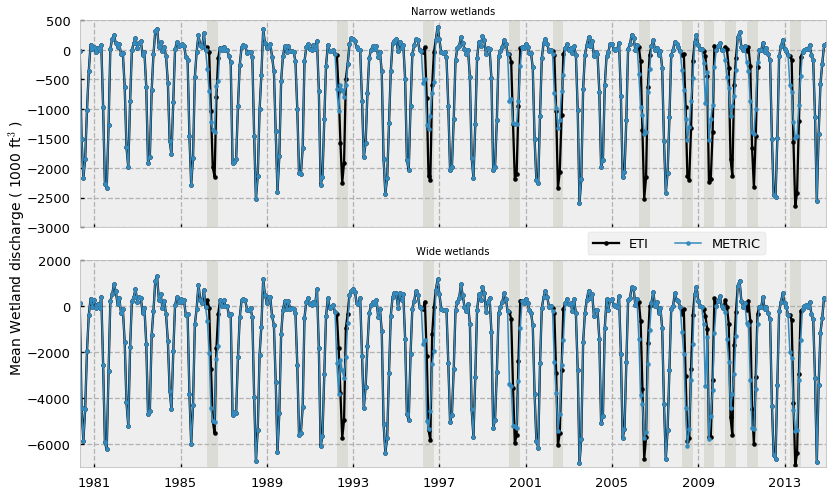

In [29]:
#------------------------------------------------------------------------------
# Plot 1: old narrow wetlands vs new narrow wetlands. Shade in METRIC years
wetlandflag = FPTnew.columns.str.contains('W')
#FPTnew.groupby(FPTnew.columns.str[0],axis=1).mean().plot()

fig, ax = plt.subplots(2,1,sharex=True)
fillidx = FPTnew.index.isin(cols)
ax[0].fill_between(FPTnew.index,-7e3,1.5e3,where = fillidx,facecolor=[0.8, 0.8, 0.75],alpha=0.5)
ax[0].plot(FPTold.filter(regex='N.*').mean(axis=1),'.k-',label=r'ETI')
ax[0].plot(FPTnew.filter(regex='N.*').mean(axis=1),label=r'METRIC',linewidth=1.5,marker='.')
ax[0].set_ylim((-3e3,5e2))

ax[1].fill_between(FPTnew.index,-7e4,1.5e4,where = fillidx,facecolor=[0.8, 0.8, 0.75],alpha=0.5)
ax[1].plot(FPTold.filter(regex='W.*').mean(axis=1),'.k-',label=r'ETI',)
ax[1].plot(FPTnew.filter(regex='W.*').mean(axis=1),label=r'METRIC',linewidth=1.5,marker='.')
ax[1].set_ylim((-7e3,2e3))

ax[0].set_xlim(('1980-5-1','2014-12-1'))
ax[0].set_title('Narrow wetlands',fontsize=10)
ax[1].set_title('Wide wetlands',fontsize=10)
fig.text(0.04,0.5,r'Mean Wetland discharge ( 1000 ft$^3$ )',
         va='center', rotation='vertical',
         fontsize=14)
fig.tight_layout(rect=(.05,0,1,1))
ax[0].legend(bbox_to_anchor=[0.8, -.08], loc='center',ncol=2)

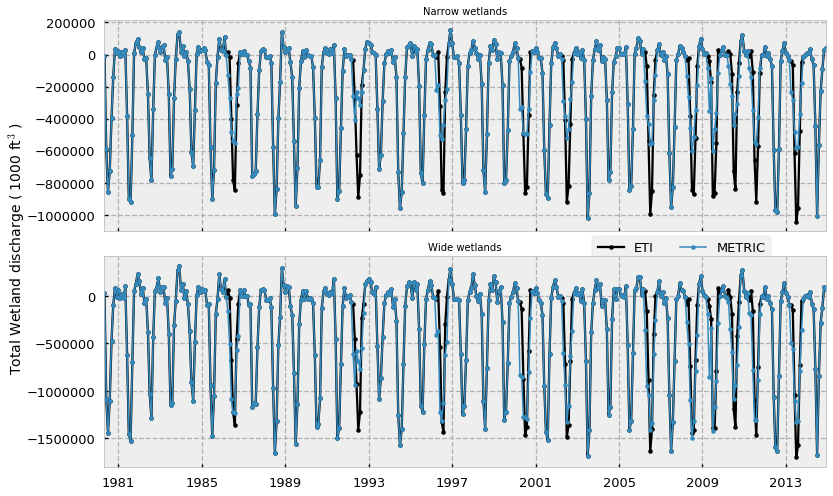

In [30]:
# ----------------------------------------------------------------------------
# Plot 1b. Same as above, but sum of all narrow or wide wetlands

fig1b, ax1b = plt.subplots(2,1,sharex=True)
fillidx = FPTnew.index.isin(cols)
#ax[0].fill_between(FPTnew.index,-7e3,1.5e3,where = fillidx,facecolor=[0.8, 0.8, 0.75],alpha=0.5)
ax1b[0].plot(FPTold.filter(regex='N.*').sum(axis=1),'.k-',label=r'ETI')
ax1b[0].plot(FPTnew.filter(regex='N.*').sum(axis=1),label=r'METRIC',linewidth=1.5,marker='.')
#ax1b[0].set_ylim((-3e3,5e2))

#ax[1].fill_between(FPTnew.index,-7e4,1.5e4,where = fillidx,facecolor=[0.8, 0.8, 0.75],alpha=0.5)
ax1b[1].plot(FPTold.filter(regex='W.*').sum(axis=1),'.k-',label=r'ETI',)
ax1b[1].plot(FPTnew.filter(regex='W.*').sum(axis=1),label=r'METRIC',linewidth=1.5,marker='.')
#ax1b[1].set_ylim((-7e3,2e3))

ax1b[0].set_xlim(('1980-5-1','2014-12-1'))
ax1b[0].set_title('Narrow wetlands',fontsize=10)
ax1b[1].set_title('Wide wetlands',fontsize=10)
fig1b.text(0.04,0.5,r'Total Wetland discharge ( 1000 ft$^3$ )',
         va='center', rotation='vertical',
         fontsize=14)
fig1b.tight_layout(rect=(.05,0,1,1))
ax1b[0].legend(bbox_to_anchor=[0.8, -.08], loc='center',ncol=2)

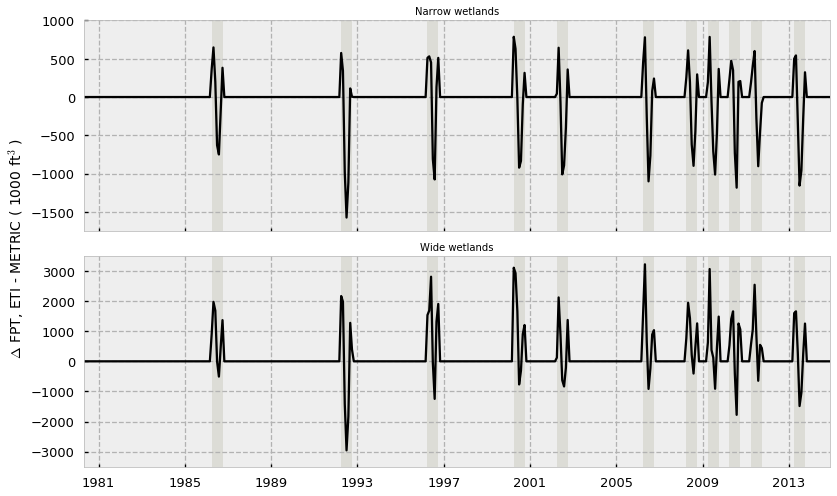

In [31]:
#------------------------------------------------------------------------------
# Fig 2. Differences
fig2, ax2 = plt.subplots(2,1,sharex=True)
fillidx = FPTnew.index.isin(cols)
ax2[0].fill_between(FPTnew.index,-2e3,1e3,where = fillidx,facecolor=[0.8, 0.8, 0.75],alpha=0.5)
ax2[0].plot(FPTold.filter(regex='N.*').mean(axis=1)-FPTnew.filter(regex='N.*').mean(axis=1),'k',label=r'Narrow')
ax2[0].set_ylim(-1.75e3,1e3)

ax2[1].fill_between(FPTnew.index,-4e3,4e3,where = fillidx,facecolor=[0.8, 0.8, 0.75],alpha=0.5)
ax2[1].plot(FPTold.filter(regex='W.*').mean(axis=1)-FPTnew.filter(regex='W.*').mean(axis=1),'k',label=r'Wide')
ax2[0].set_xlim(('1980-5-1','2014-12-1'))
ax2[1].set_ylim(-3.5e3,3.5e3)

ax2[0].set_title('Narrow wetlands',fontsize=10)
ax2[1].set_title('Wide wetlands',fontsize=10)
fig2.text(0.035,0.5,r'$\Delta$ FPT, ETI - METRIC ( 1000 ft$^3$ )',
         va='center', rotation='vertical',
         fontsize=14)
fig2.tight_layout(rect=(.05,0,1,1))

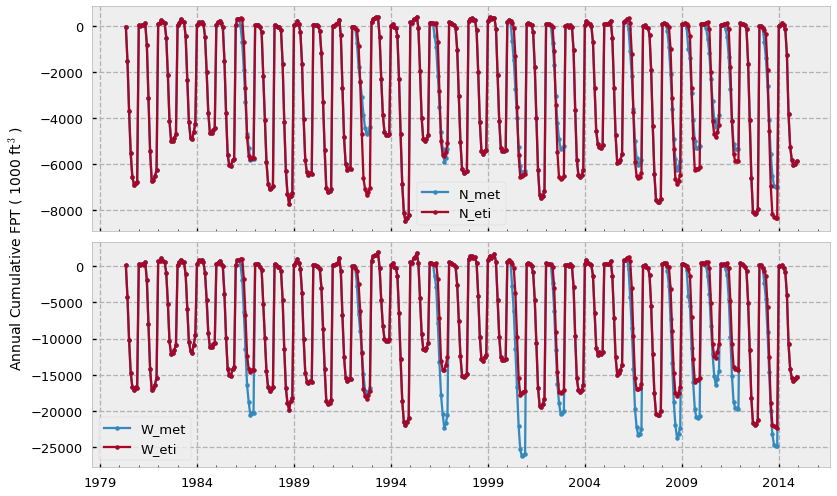

In [32]:
#------------------------------------------------------------------------------
# Fig 3 Monthly Cumulative FPT per year
FPTaccum=pd.merge(FPTnew.groupby(FPTnew.columns.str[0],axis=1).mean().groupby(FPTnew.index.year).cumsum(),
                  FPTold.groupby(FPTold.columns.str[0],axis=1).mean().groupby(FPTold.index.year).cumsum(),
                  left_index=True, right_index=True,
                  suffixes=('_met','_eti'))
fig3,ax3 = plt.subplots(2,1,sharex=True)
FPTaccum.iloc[:,[0,2]].plot(marker='.',ax=ax3[0])
FPTaccum.iloc[:,[1,3]].plot(marker='.',ax=ax3[1])
fig3.text(0.035,0.5,r'Annual Cumulative FPT ( 1000 ft$^3$ )',
         va='center', rotation='vertical',
         fontsize=14)
fig3.tight_layout(rect=(.05,0,1,1))

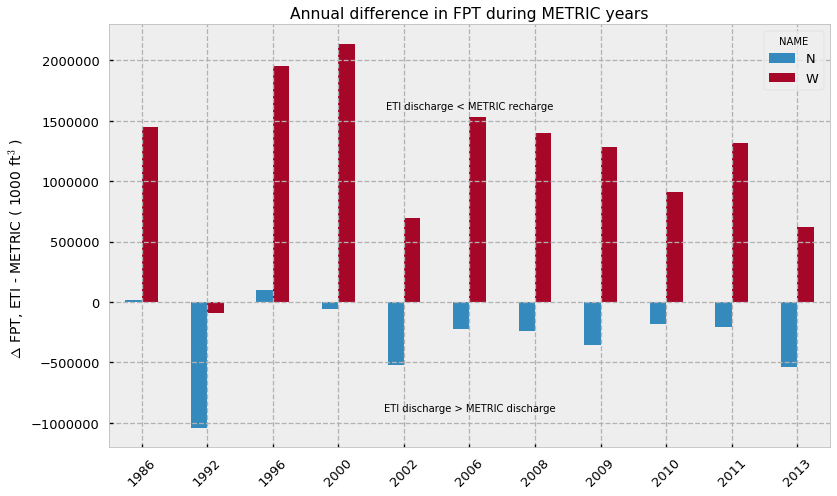

In [33]:
#------------------------------------------------------------------------------
# Fig 4 Annual Difference
FPTnewA = FPTnew.resample('A').sum()
FPToldA = FPTold.resample('A').sum()
#ax4=FPTnewA.sum(axis=1).plot(label='METRIC')
#FPToldA.sum(axis=1).plot(ax=ax3,label='ETI')
#FPToldA.groupby(FPToldA.columns.str[0],axis=1).sum().plot()
FPTdiffA = (FPToldA - FPTnewA).groupby(FPToldA.columns.str[0],axis=1).sum()
FPTdiffA = FPTdiffA.loc[FPTdiffA.index.year.isin(cols.year)]
FPTdiffA.index=FPTdiffA.index.year

# Fig 4: Annual FPT during years with METRIC
fig4,ax4 = plt.subplots(1,1)
FPTdiffA.plot(kind='bar', ax=ax4 )
plt.xticks(rotation=45)
ax4.text(5,1600000,r'ETI discharge < METRIC recharge',ha='center')
ax4.text(5,-900000,r'ETI discharge > METRIC discharge',ha='center')
fig4.text(.035,0.5,r'$\Delta$ FPT, ETI - METRIC ( 1000 ft$^3$ )',
         va='center', rotation='vertical',
         fontsize=14)
plt.title('Annual difference in FPT during METRIC years')
plt.tight_layout(rect=(.05,0,1,1))

### Peak ET is lower for METRIC, but increases earlier and stays high longer

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1804: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


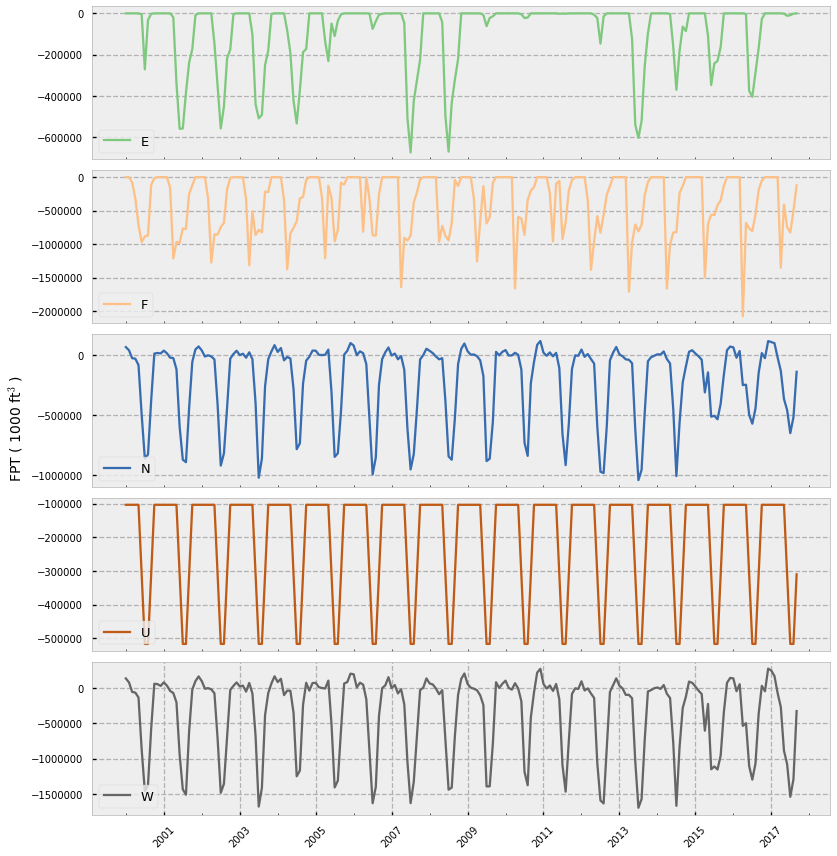

In [34]:
#-----------------------------------------------------------------
#FIG 6: ALL FPT
f=r'D:\ESRP\RechargeData_Alex\FPT\ESPAM2_FPT_197905_201709.csv'
dfMOD = pd.read_csv(f, header= 0, index_col=0)
stress_periods = ['S'+str(x) for x in  np.arange(417,450)]
#dfFPTp = dfFPTp.T
#dfFPTp.columns = stress_periods
#
#temp = dfMOD.loc[dfMOD.index.str.contains('W|N'),:'S416']
#temp = temp.merge(dfFPTp,right_index=True,left_index=True)
#dfMOD.loc[dfMOD.index.str.contains('W|N'),:] = temp
#dfMOD.apply(np.round).to_csv(r'D:\ESRP\RechargeData_Alex\FPT\ESPAM2_FPT_197905_201709.FPT')
FPTtype = dfMOD.index.str[0]
FPTts = dfMOD.apply(lambda x: (x - x.mean())/x.std(),axis=1).groupby(FPTtype).mean().T
FPTts = dfMOD.groupby(FPTtype).sum().T
FPTts.index = pd.date_range(end='2017-9-1',freq='MS',periods=len(FPTts))
FPTts = FPTts.div(1000)

figFPT, axFPT = plt.subplots(1,1,figsize=(12,12))
FPTts['2000-1-1':].plot(ax=axFPT,cmap='Accent',subplots=True,layout=(5,1),fontsize=10)
figFPT.text(.035,0.5,r'FPT ( 1000 ft$^3$ )',
         va='center', rotation='vertical',
         fontsize=14)
axes = figFPT.get_axes()
[a.legend( loc='lower left') for a in axes ]
[plt.setp(a.xaxis.get_majorticklabels(),rotation=45) for a in axes]
[ a.set_xticks([]) for a in axes[0:4] ]
figFPT.tight_layout(rect=(.05,0,1,1))

# ARIMA models vs. monthly averages

In [40]:
#---------
# ARIMA
# --------
# Load ARIMA dictionary
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
#from load_idwr import parse_ETIDAHO_monthly
import pickle
# Load ETIdaho data
f=r'D:\ESRP\RechargeData_Alex\FPT\Wetlands\ETIdaho\WetlandsETIdaho_201612.csv'
dfETI = pd.read_csv(f,header=[0,1,2],index_col=0,parse_dates=True)
# Load model results
with open('D:/ESRP/RechargeData_Alex/FPT/Wetlands/ETIdaho_ARIMA_gridsearch_results.pkl','rb') as f:
    dARIMA = pickle.load(f)
    
def ForecastTS( data , ARIMAparams ):
    # Scale Data
    scaler = StandardScaler()
    scaler.fit(data.dropna().values.reshape(-1,1))
    datanorm = data.dropna().apply(lambda x: scaler.transform(x)[0][0])
    datanorm = datanorm.resample('MS').asfreq()
    # Run model
    mod = sm.tsa.statespace.SARIMAX(datanorm,
                                    order= ARIMAparams[0],
                                    seasonal_order=ARIMAparams[1],
                                    enforce_stationarity=False,
                                    enforce_intertibility=True)
    results=mod.fit()
    # Make predictions
    datapred = results.predict(start = data.first_valid_index() , end= pd.datetime(2017,9,1))
    datapred = pd.Series( scaler.inverse_transform( datapred ), 
                         index = datapred.index,
                         name='predict')
    # Remove negative ET, replace with min of real data
    datapred = datapred.where(datapred > 0 , data.min())
    
    # Place predicted data where data is NAN
    data = pd.concat([data,datapred],axis=1) 
    data = data.iloc[:,0].where(np.isfinite(data.iloc[:,0] ),data['predict'])
   
    return datapred
    
      
ET_RMSE = {}
rmse = lambda x,y: round(np.sqrt(mean_squared_error(x,y)),2)
for key in dARIMA.keys():
    #print('Running {} {} ARIMA'.format(key[0],key[1]))
    data = dfETI.loc[:,key[0:2]].squeeze()
    datapred = ForecastTS(data, dARIMA[key[0:2]]['Params'])
    alldata = pd.concat([data,datapred],axis=1)
    alldata = alldata['1980-1-1':]
    monthmean = data.groupby(data.index.month).mean()
    alldata['mean']=alldata.index.month.map(monthmean.to_dict())
    ET_RMSE[key] = pd.Series({'SARIMA':rmse(alldata.dropna().iloc[:,0],alldata.dropna().loc[:,'predict']),
           'mean': rmse(alldata.dropna().iloc[:,0],alldata.dropna().loc[:,'mean']) } )
    # Plot Forecast

df = pd.concat(ET_RMSE,axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [41]:
df.T

SARIMA   mean
AMERICAN_FALLS_1_SW     Wetlands--large stands    23.01  26.51
                        Wetlands--narrow stands   34.14  39.20
ARCO                    Wetlands--large stands    25.74  28.36
                        Wetlands--narrow stands   37.59  41.70
BLISS                   Wetlands--large stands    24.02  26.92
                        Wetlands--narrow stands   35.34  40.14
BURLEY_FAA_AP           Wetlands--large stands    23.85  25.45
                        Wetlands--narrow stands   34.83  37.74
DUBOIS_EXPERIMENT_STN   Wetlands--large stands    22.29  23.71
                        Wetlands--narrow stands   32.65  35.69
FORT_HALL_INDIAN_AGENCY Wetlands--large stands    24.46  26.42
                        Wetlands--narrow stands   35.52  38.68
HAMER_4_NW              Wetlands--large stands    23.68  24.82
                        Wetlands--narrow stands   34.83  36.67
IDAHO_FALLS_FAA_ARPT    Wetlands--large stands    25.54  27.52
                        Wetlands--narrow stands   37.65  40.88
JEROME                  Wetlands--large stands    23.03  24.59
                        Wetlands--narrow stands   34.05  36.55
PICABO                  Wetlands--large stands    20.39  21.91
                        Wetlands--narrow stands   29.65  32.11
POCATELLO_WB_AP         Wetlands--large stands    26.69  28.43
                        Wetlands--narrow stands   38.48  42.01
REXBURG_RICKS_COLLEGE   Wetlands--large stands    21.48  22.87
                        Wetlands--narrow stands   30.92  33.32
SHOSHONE                Wetlands--large stands    23.85  26.76
                        Wetlands--narrow stands   35.08  39.58
ST_ANTHONY              Wetlands--large stands    23.75  25.34
                        Wetlands--narrow stands   34.35  37.19
TWIN_FALLS_WSO          Wetlands--large stands    19.51  19.91
                        Wetlands--narrow stands   28.79  29.67

# Water budget components
## DIV

In [5]:
f = os.path.join(root,'DIV','ESPAM22_DIVS_WORK_FILE_20180216.xlsx') 
d= {}
with pd.ExcelFile(f) as xls:
    sheets = xls.sheet_names
    with open(os.path.join(root,'DIV','ESPAM2x_201709.csv'),'w') as fout:
        print('Writing...',end='')
        for sheet in sheets:
            if 'IESW' in sheet:
                print('{},'.format(sheet),end='')
                df = xls.parse(sheet, nrows= 42, usecols =12,header= None ) 
                df.iloc[3:,1:] = df.iloc[3:,1:].astype(float)
                df2 = pd.DataFrame(data = df.iloc[3:,1:].values,
                                   index=df.iloc[3:,0],
                                   columns=df.iloc[2,1:].values)
                df2 = df2.T.unstack()
                df2.index = [pd.datetime.strptime(x[0][-4:]+x[1],'%Y%b') for x in df2.index.tolist()]
                d[sheet] = df2
                
xls.close() 
df = pd.concat(d,axis=1)
df.where(df >= 0,inplace=True)

Writing...IESW000,IESW001,IESW002,IESW005,IESW008,IESW009,IESW010,IESW011,IESW012,IESW014,IESW015,IESW016,IESW018,IESW019,IESW020,IESW022,IESW025,IESW027,IESW028,IESW029,IESW030,IESW032,IESW034,IESW035,IESW036,IESW037,IESW038,IESW039,IESW040,IESW044,IESW051,IESW052,IESW053,IESW055,IESW056,IESW057,IESW058,IESW060,IESW061,IESW062,IESW063,

Text(0.5,0,'Water Year')

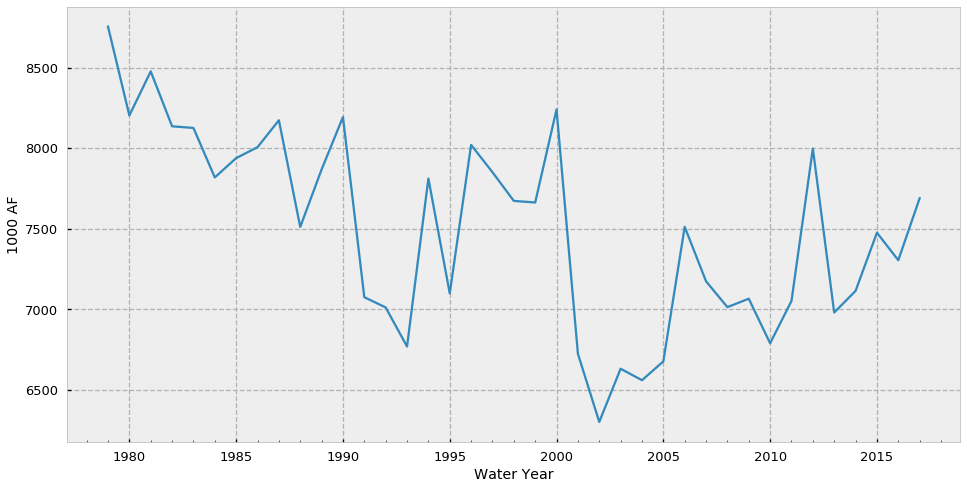

In [6]:
axDIV = df.sum(axis=1).resample('A').sum().plot(figsize=(16,8))
axDIV.set_ylabel('1000 AF')
axDIV.set_xlabel('Water Year')


## Non-Snake perched river seepage

In [7]:
f = os.path.join(root,'PCH','ESPAM22_PerchedRivSeep_201709.xlsx')
df = pd.read_excel(f ,sheet_name='ALL',header=[2,3],index_col=[0,1],parse_dates=True)
df.columns = df.columns.droplevel(1)
df.index = df.index.droplevel(1)
df = df.T

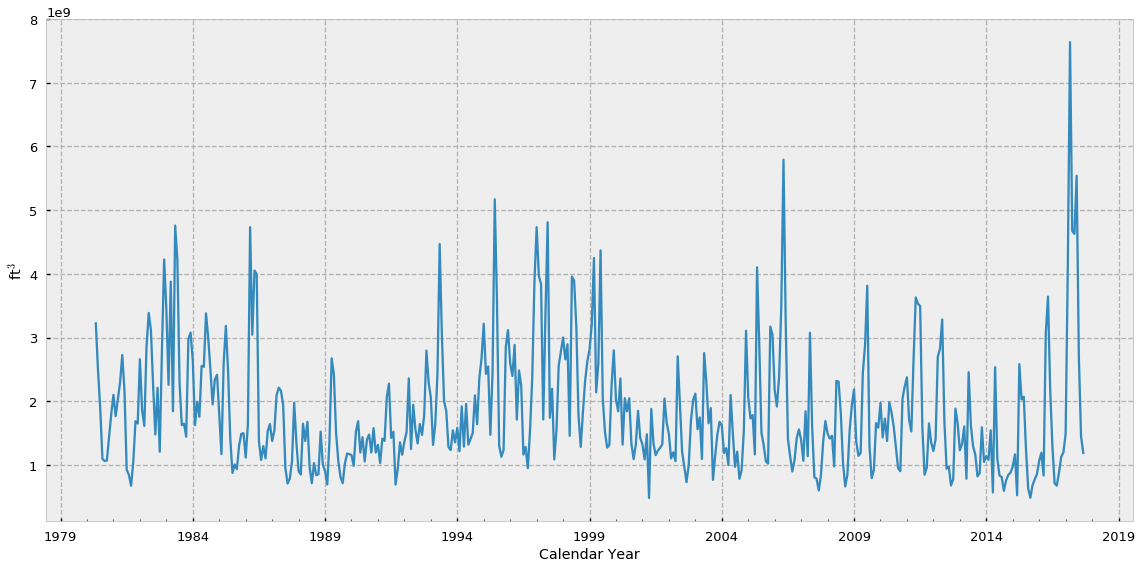

In [8]:
figPCH,axPCH = plt.subplots(1,1,figsize=(16,8))
df.sum(axis=1).plot(ax=axPCH)
axPCH.set_ylabel(r'ft$^3$')
axPCH.set_xlabel('Calendar Year')
figPCH.tight_layout()

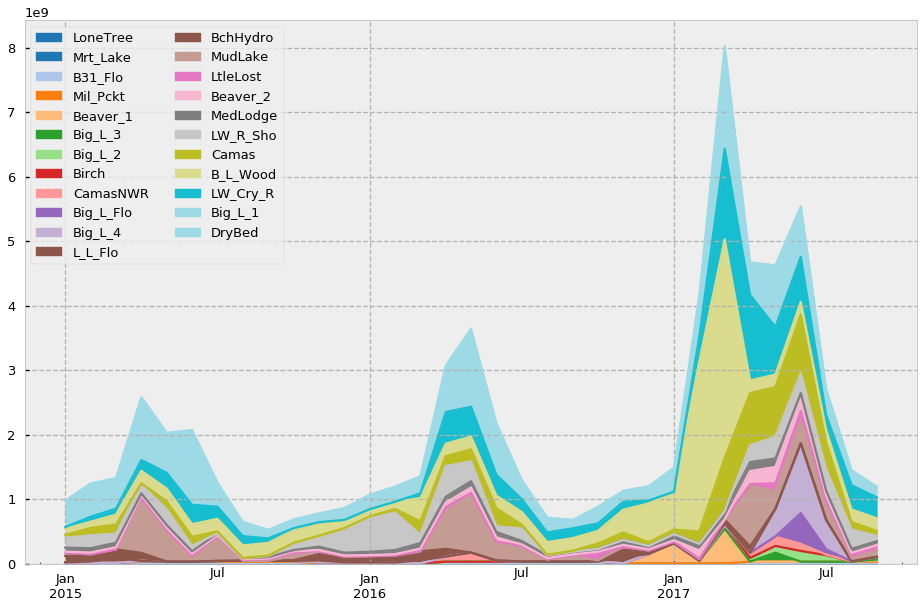

In [9]:
# Plot by reach, removing negative mudlake values
df.loc['2015-1-1':,df.mean().sort_values().index].where(df >=0,0).plot(kind='area',cmap='tab20',figsize=(16,10))
plt.legend(loc='upper left',ncol=2)

## Non-irrigated Recharge

In [14]:
f = os.path.join(root,'NIR','NIR_201709.csv')
df = pd.read_csv( f, index_col = 3, header= 0)
df = df.filter(regex='S.*')
# Pick random period after 343 to identify inactive cells (NIR == 0)
df.columns = df.columns.map(sp2ts)

Text(0,0.5,'NIR (in)')

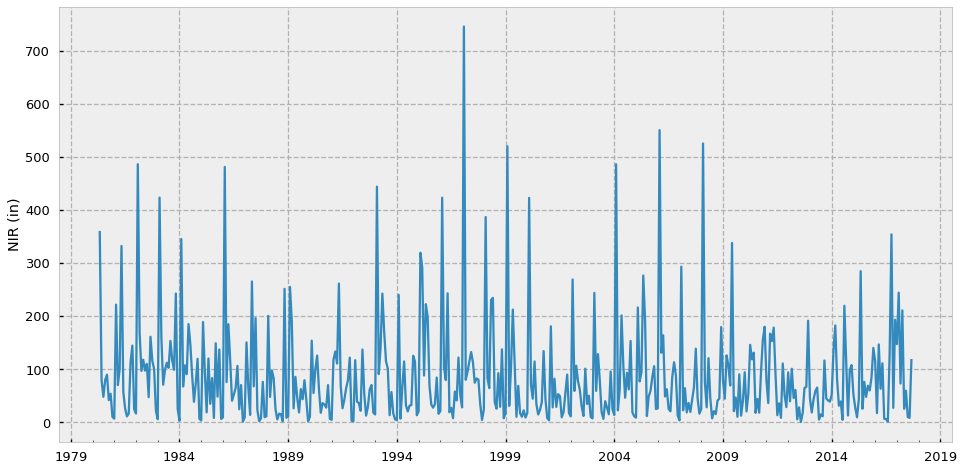

In [15]:
df.where(df.iloc[:,418] > 0 ).sum().plot(figsize=(16,8))
plt.ylabel('NIR (in)')

## Tributary Underflow

In [16]:
f = os.path.join(root,'TRB','TRBCalc','TRBCalc_throughSP449_201709.csv')
df = pd.read_csv(f, index_col=0, header=0)
df = df.filter(regex='SP.*')
df.columns = df.columns.map(dict(zip(['SP{0:03d}'.format(x) for x in  np.arange(1,450)],stress_ts)))

Text(0,0.5,'Volume (ft$^3$)')

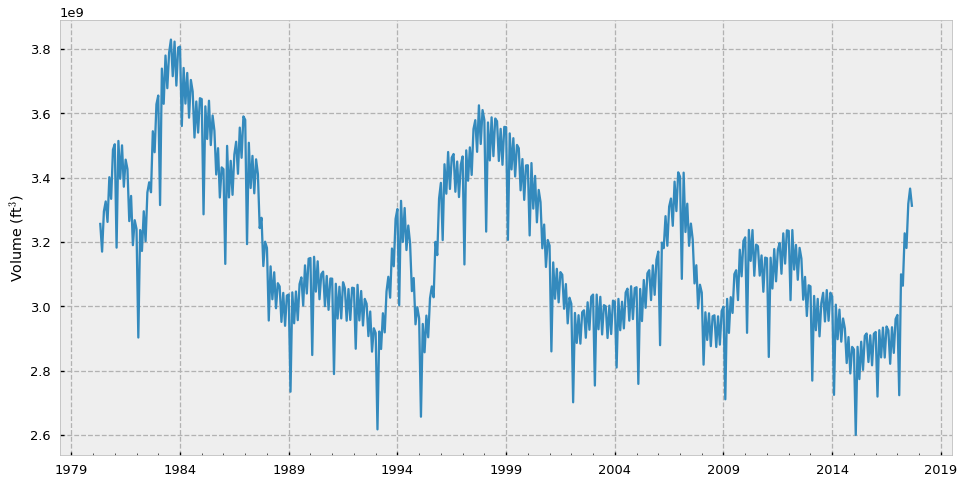

In [17]:
axTRB = df.sum().plot(figsize=(16,8))
axTRB.set_ylabel('Volume (ft$^3$)')

## Offsite 

In [30]:
f = os.path.join(root,'OFF','ESPAM2x_offsite_201709.csv')
dfOFF = pd.read_csv(f, index_col=0, header=0)
dfOFF.columns = dfOFF.columns.map(dict(zip(['SP{0:03d}'.format(x) for x in np.arange(1,450)],stress_ts)))

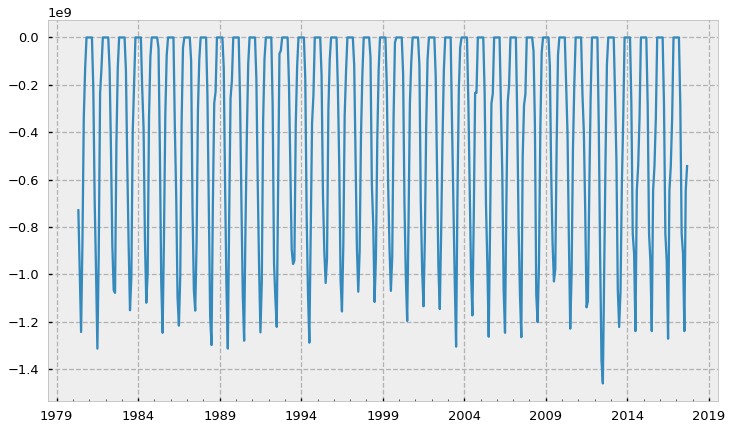

In [33]:
dfOFF.sum().plot()

## CNL

In [36]:
f = os.path.join(root,'CNL','E22_CNL_DATA_20170710.csv')
dfCNL = pd.read_csv(f, index_col=[0,1], header = 0)
dfCNL.columns = dfCNL.columns.map(dict(zip(['S{}'.format(x) for x in np.arange(1,450)],stress_ts)))

In [42]:
dfCNL.head()

,,1980-05-01 00:00:00,1980-06-01 00:00:00,1980-07-01 00:00:00,1980-08-01 00:00:00,1980-09-01 00:00:00,1980-10-01 00:00:00,1980-11-01 00:00:00,1980-12-01 00:00:00,1981-01-01 00:00:00,1981-02-01 00:00:00,...,2016-12-01 00:00:00,2017-01-01 00:00:00,2017-02-01 00:00:00,2017-03-01 00:00:00,2017-04-01 00:00:00,2017-05-01 00:00:00,2017-06-01 00:00:00,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00
STRESS,FACTOR,,,,,,,,,,,,,,,,,,,,,
A&B,1.000000,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,...,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15
AbSpring_hi,0.980685,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,...,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04
AbSpring_lo,0.980685,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,...,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02
AbSpring_MoreL_Rock,0.980685,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,...,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10
AbSpring_Rock_Bifurc,0.980685,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,...,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33


## ENT

## ETI